<a href="https://colab.research.google.com/github/Hailemicael/NLP_Project/blob/master/Copy_of_NLP_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wikipedia-api

In [ ]:
import pandas as pd
import wikipediaapi
from bs4 import BeautifulSoup
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Function to fetch content from Wikipedia using wikipediaapi
def fetch_content(title, wiki_wiki):
    # Fetches content from Wikipedia for a given title.
    page_py = wiki_wiki.page(title)
    content = page_py.text

    # Clean the content
    cleaned_content = clean_text(content)

    return cleaned_content

# Function to clean text (remove HTML tags, references, etc.)
def clean_text(text):
    # Remove HTML tags and comments
    soup = BeautifulSoup(text, "html.parser")
    clean_text = soup.get_text(separator=" ")

    # Remove special characters and non-alphabetic characters
    clean_text = re.sub(r"[^a-zA-Z\s]", "", clean_text)

    # Tokenize the text
    tokens = word_tokenize(clean_text.lower())

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove extra whitespaces
    clean_text = " ".join(tokens)

    return clean_text

# Create an initial DataFrame
df = pd.DataFrame(columns=["text", "label"])

# Set up wikipediaapi
wiki_wiki = wikipediaapi.Wikipedia('NLP_Project(hailelulseged281913@gmail.com)', 'en')

# List of medical and non-medical keywords
medical_keywords = ["Medicine", "Cardiology", "Surgery", "Health","Pharmacy", "Immunology",
                    "Pathology", "Pediatrics", "Oncology", "Neurology", "Dentistry","vascular",
                    "orthopedic", "dermatology", "endocrinology", "gastroenterology", "pulmonary", "neurosurgery",
                    "ophthalmology", "urology", "radiology", "anesthesiology", "genetics", "oncologist", "hematology",
                    "immunotherapy", "pediatrician", "psychiatry", "dentist", "Anatomy",
                    "Physiology", "Biochemistry","balanced diet","Ailment", "Affliction", "Illness", "Sickness", "Acute",
                    "Hereditary", "Infectious", "Pandemic","nurse","Doctor","Alzheimer",]
non_medical_keywords = ["Art", "Literature", "Philosophy", "Science", "Technology", "Space",
                        "Environment", "Food", "Cuisine", "Recipes", "Cooking", "History", "Ancient_Civilizations",
                        "Archaeology", "painting", "sculpture", "literary", "fiction", "poetry", "philosopher",
                        "culinary", "gastronomy", "recipe", "culinary", "history", "historical", "architectural",
                        "archaeological", "civilization","culture", "Engineering", "Astronomy", "Cosmology","country","Industry","ocean","charger","battery"]

# Fetch content for medical keywords
medical_content_list = [fetch_content(keyword, wiki_wiki) for keyword in medical_keywords]

# Fetch content for non-medical keywords
non_medical_content_list = [fetch_content(keyword, wiki_wiki) for keyword in non_medical_keywords]

# Create a DataFrame with the fetched data
medical_data = {"text": medical_content_list, "label": ["medical"] * len(medical_content_list)}
non_medical_data = {"text": non_medical_content_list, "label": ["non-medical"] * len(non_medical_content_list)}

df_medical = pd.DataFrame(medical_data)
df_non_medical = pd.DataFrame(non_medical_data)

# Concatenate the dataframes and shuffle rows
df = pd.concat([df_medical, df_non_medical], ignore_index=True).sample(frac=1)

# Check the updated dataset
print("Updated Dataset:")
print(df)
df.to_csv('medical_non_medical_dataset.csv', index=False)
print("Dataset saved as 'medical_non_medical_dataset.csv'")



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Updated Dataset:
                                                 text        label
52  cuisine style cooking characterized distinctiv...  non-medical
11  blood vessel component circulatory system tran...      medical
40  pandemic pandemik epidemic infectious disease ...      medical
8   oncology branch medicine deal study treatment ...      medical
77  country distinct part world state nation polit...  non-medical
..                                                ...          ...
75  astronomy natural science study celestial obje...  non-medical
32  healthy diet diet maintains improves overall h...      medical
66  recipe set instruction describes prepare make ...  non-medical
55  history derived ancient greek histora inquiry ...  non-medical
65  gastronomy study relationship food culture art...  non-medical

[82 rows x 2 columns]
Dataset saved as 'medical_non_medical_dataset.csv'


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# Load the cleaned dataset
df = pd.read_csv('medical_non_medical_dataset.csv')

# Check class distribution
print("Original Data Distribution:")
print(df['label'].value_counts())

# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.3, random_state=100)

# Handle missing values in X_test
X_test = X_test.fillna('')  # Replace NaN with an empty string or any other placeholder

# Handle missing values in X_train
X_train = X_train.fillna('')  # Replace NaN with an empty string or any other placeholder

# Feature Extraction (TF-IDF)
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Resampling using SMOTE
sampler = SMOTE(sampling_strategy='auto', k_neighbors=5)
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_tfidf, y_train)

# Model Selection and Training (Naive Bayes)
nb_model = MultinomialNB()
nb_model.fit(X_train_resampled, y_train_resampled)

# Model Evaluation (Naive Bayes)
nb_predictions = nb_model.predict(X_test_tfidf)
nb_accuracy = accuracy_score(y_test, nb_predictions)
print(f"\nNaive Bayes Accuracy: {nb_accuracy}")
print("Naive Bayes Classification Report:\n", classification_report(y_test, nb_predictions))

# Example of making predictions on more new data using Naive Bayes
new_data_extended = [
    "heart disease",
    "expression varies across cultures.",
    "New year in Ethiopia is good.",
    "my health is not good",
    "doctors support patient",
    "let us see my country.",
    "The latest novel by a famous author.",
    "Advancements in artificial intelligence.",
    "Exploring outer space and galaxies.",
    "The best recipe for chocolate cake.",
    "Historical landmarks in ancient civilizations.",
    "Innovations in technology and robotics.",
    "Creating beautiful paintings and sculptures.",
    "The impact of climate change on the environment.",
    "The science of astronomy and celestial bodies."
]

new_data_extended_tfidf = tfidf_vectorizer.transform(new_data_extended)
new_predictions_extended = nb_model.predict(new_data_extended_tfidf)

print("\nNaive Bayes Predictions on more new data:")
for text, prediction in zip(new_data_extended, new_predictions_extended):
    print(f"{text} - Predicted: {prediction}")


Original Data Distribution:
medical        44
non-medical    38
Name: label, dtype: int64

Naive Bayes Accuracy: 0.92
Naive Bayes Classification Report:
               precision    recall  f1-score   support

     medical       1.00      0.88      0.93        16
 non-medical       0.82      1.00      0.90         9

    accuracy                           0.92        25
   macro avg       0.91      0.94      0.92        25
weighted avg       0.93      0.92      0.92        25


Naive Bayes Predictions on more new data:
heart disease - Predicted: medical
expression varies across cultures. - Predicted: non-medical
New year in Ethiopia is good. - Predicted: non-medical
my health is not good - Predicted: medical
doctors support patient - Predicted: medical
let us see my country. - Predicted: non-medical
The latest novel by a famous author. - Predicted: non-medical
Advancements in artificial intelligence. - Predicted: non-medical
Exploring outer space and galaxies. - Predicted: non-medical
T

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# Load the cleaned dataset
df = pd.read_csv('medical_non_medical_dataset.csv')

# Check class distribution
print("Original Data Distribution:")
print(df['label'].value_counts())

# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.3, random_state=100)

# Handle missing values in X_test
X_test = X_test.fillna('')  # Replace NaN with an empty string or any other placeholder

# Handle missing values in X_train
X_train = X_train.fillna('')  # Replace NaN with an empty string or any other placeholder

# Feature Extraction (TF-IDF)
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Resampling using SMOTE
sampler = SMOTE(sampling_strategy='auto', k_neighbors=5)
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_tfidf, y_train)

# Model Selection and Training (Logistic Regression)
model = LogisticRegression(random_state=100)
model.fit(X_train_resampled, y_train_resampled)

# Model Evaluation
predictions = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, predictions)
print(f"\nAccuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_test, predictions))

# Example of making predictions on more new data using Naive Bayes
new_data_extended = [
    "heart disease",
    "expression varies across cultures.",
    "New year in Ethiopia is good.",
    "my health is not good",
    "doctors support patient",
    "let us see my country.",
    "The latest novel by a famous author.",
    "Advancements in artificial intelligence.",
    "Exploring outer space and galaxies.",
    "The best recipe for chocolate cake.",
    "Historical landmarks in ancient civilizations.",
    "Innovations in technology and robotics.",
    "Creating beautiful paintings and sculptures.",
    "The impact of climate change on the environment.",
    "The science of astronomy and celestial bodies."
]

new_data_extended_tfidf = tfidf_vectorizer.transform(new_data_extended)
new_predictions_extended = nb_model.predict(new_data_extended_tfidf)

print("\nNaive Bayes Predictions on more new data:")
for text, prediction in zip(new_data_extended, new_predictions_extended):
    print(f"{text} - Predicted: {prediction}")



Original Data Distribution:
medical        44
non-medical    38
Name: label, dtype: int64

Accuracy: 0.92
Classification Report:
               precision    recall  f1-score   support

     medical       1.00      0.88      0.93        16
 non-medical       0.82      1.00      0.90         9

    accuracy                           0.92        25
   macro avg       0.91      0.94      0.92        25
weighted avg       0.93      0.92      0.92        25


Naive Bayes Predictions on more new data:
heart disease - Predicted: medical
expression varies across cultures. - Predicted: non-medical
New year in Ethiopia is good. - Predicted: non-medical
my health is not good - Predicted: medical
doctors support patient - Predicted: medical
let us see my country. - Predicted: non-medical
The latest novel by a famous author. - Predicted: non-medical
Advancements in artificial intelligence. - Predicted: non-medical
Exploring outer space and galaxies. - Predicted: non-medical
The best recipe for choco

In [ ]:
#Updated version with the addition of a validation set to evaluate overfitting, underfitting, and misclassification for naive_bayes

Original Data Distribution:
medical        44
non-medical    38
Name: label, dtype: int64

Validation Accuracy: 0.9
Validation Classification Report:
               precision    recall  f1-score   support

     medical       1.00      0.86      0.92         7
 non-medical       0.75      1.00      0.86         3

    accuracy                           0.90        10
   macro avg       0.88      0.93      0.89        10
weighted avg       0.93      0.90      0.90        10


Misclassified Examples on Validation Set:
Text: heredity also called inheritance biological inheritance passing trait parent offspring either asexual reproduction sexual reproduction offspring cell organism acquire genetic information parent heredity variation individual accumulate cause specie evolve natural selection study heredity biology genetics overview human eye color example inherited characteristic individual might inherit browneye trait one parent inherited trait controlled gene complete set gene within or

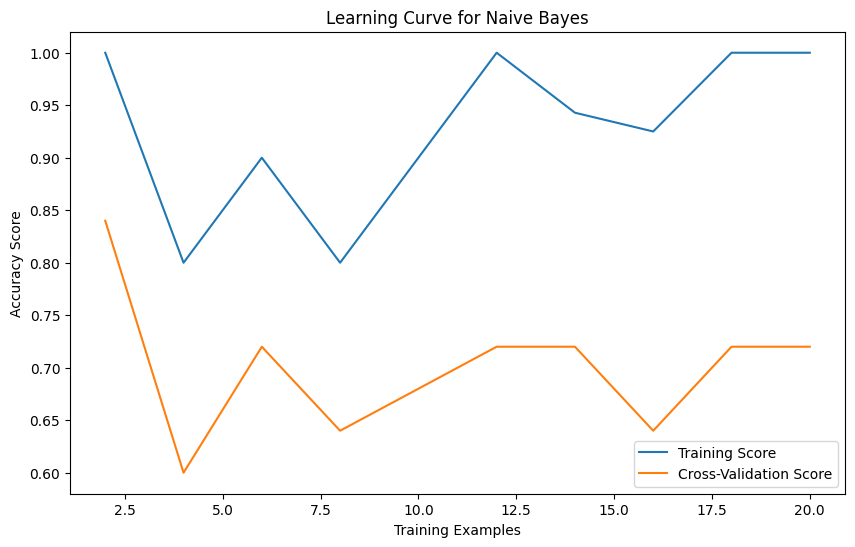


Test Accuracy: 0.96875
Test Classification Report:
               precision    recall  f1-score   support

     medical       1.00      0.94      0.97        16
 non-medical       0.94      1.00      0.97        16

    accuracy                           0.97        32
   macro avg       0.97      0.97      0.97        32
weighted avg       0.97      0.97      0.97        32


Naive Bayes Predictions on more new data:
heart disease - Predicted: medical
New year in Ethiopia is good. - Predicted: non-medical
my health is not good - Predicted: medical
doctors support patient - Predicted: medical
Advancements in artificial intelligence. - Predicted: non-medical
The best recipe for chocolate cake. - Predicted: non-medical
Historical landmarks in ancient civilizations. - Predicted: non-medical
Innovations in technology and robotics. - Predicted: non-medical
Creating beautiful paintings and sculptures. - Predicted: non-medical
The impact of climate change on the environment. - Predicted: non

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# Load the cleaned dataset
df = pd.read_csv('medical_non_medical_dataset.csv')

# Check class distribution
print("Original Data Distribution:")
print(df['label'].value_counts())

# Data Splitting
X_train, X_temp, y_train, y_temp = train_test_split(df['text'], df['label'], test_size=0.3, random_state=100)

# Further split X_temp and y_temp into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.4, random_state=100)

# Handle missing values in X_train, X_val, and X_test
X_train = X_train.fillna('')
X_val = X_val.fillna('')
X_temp = X_temp.fillna('')

# Feature Extraction (TF-IDF)
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_temp_tfidf = tfidf_vectorizer.transform(X_temp)

# Resampling using SMOTE
sampler = SMOTE(sampling_strategy='auto', k_neighbors=min(5, len(y_train) - 1))
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_tfidf, y_train)

# Model Selection and Training (Naive Bayes)
nb_model = MultinomialNB()
nb_model.fit(X_train_resampled, y_train_resampled)

# Model Evaluation on Validation Set with Misclassification Analysis
val_predictions = nb_model.predict(X_val_tfidf)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"\nValidation Accuracy: {val_accuracy}")
print("Validation Classification Report:\n", classification_report(y_val, val_predictions))

# Analyze Misclassifications on Validation Set
misclassified_indices = [i for i, (true_label, pred_label) in enumerate(zip(y_val, val_predictions)) if true_label != pred_label]
misclassified_examples = X_val.iloc[misclassified_indices].tolist()
true_labels = y_val.iloc[misclassified_indices].tolist()
pred_labels = val_predictions[misclassified_indices]

print("\nMisclassified Examples on Validation Set:")
for text, true_label, pred_label in zip(misclassified_examples, true_labels, pred_labels):
    print(f"Text: {text} - True Label: {true_label} - Predicted Label: {pred_label}")

# Learning Curve for Overfitting/Underfitting Check
train_sizes, train_scores, test_scores = learning_curve(nb_model, X_temp_tfidf, y_temp, cv=5, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-Validation Score')
plt.title('Learning Curve for Naive Bayes')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy Score')
plt.legend()
plt.show()

# Model Evaluation on Test Set
X_temp_resampled, y_temp_resampled = sampler.fit_resample(X_temp_tfidf, y_temp)
test_predictions = nb_model.predict(X_temp_resampled)
test_accuracy = accuracy_score(y_temp_resampled, test_predictions)
print(f"\nTest Accuracy: {test_accuracy}")
print("Test Classification Report:\n", classification_report(y_temp_resampled, test_predictions))

# Example of making predictions on more new data using Naive Bayes
new_data_extended = [
    "heart disease",
    "New year in Ethiopia is good.",
    "my health is not good",
    "doctors support patient",
    "Advancements in artificial intelligence.",
    "The best recipe for chocolate cake.",
    "Historical landmarks in ancient civilizations.",
    "Innovations in technology and robotics.",
    "Creating beautiful paintings and sculptures.",
    "The impact of climate change on the environment.",
    "The science of astronomy and celestial bodies."
]

new_data_extended_tfidf = tfidf_vectorizer.transform(new_data_extended)
new_predictions_extended = nb_model.predict(new_data_extended_tfidf)

print("\nNaive Bayes Predictions on more new data:")
for text, prediction in zip(new_data_extended, new_predictions_extended):
    print(f"{text} - Predicted: {prediction}")
